In [1]:
import numpy
import bokeh.plotting as bplot
bplot.output_notebook()
from matplotlib import pyplot
%matplotlib notebook
import seaborn

BokehJS successfully loaded.

In [2]:
from soapy import WFS, confParse
from aotools import circle

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


In [3]:
SOAPY_CONF = "conf/test_conf.py"

In [4]:
# load Soapy config
config = confParse.Configurator(SOAPY_CONF)
config.loadSimParams()
config.wfss[0].pxlsPerSubap = 30
config.wfss[0].subapThreshld = 1.
mask = circle.circle(config.sim.pupilSize/2., config.sim.simSize)

In [5]:
# One arcec in tilt Amp across scope
tilt_rad = 1./3600 * numpy.pi/180
tilt_amp = tilt_rad*config.tel.telDiam/2.
tilt_amp/(550e-9)

35.25917680796625

In [6]:
PXL_SCALE = 1 #asec/pxl

In [7]:
# Measure current pixel scale
maxTilt = 4*PXL_SCALE # arcsecs
tilts_asec = numpy.linspace(-maxTilt, maxTilt, 10)

tilts_rad = (tilts_asec/3600.) * (numpy.pi/180)
# Must convert arcsecs of tilt to amp in nm
tiltAmps = 1e9 * (tilts_rad * config.tel.telDiam/2.)# in nm amp

# Make a unit tilt to multiply
coords = numpy.linspace(-1, 1, config.sim.pupilSize)
coords = numpy.pad(coords, pad_width=[config.sim.simPad,]*2, mode="constant")
tilt = numpy.meshgrid(coords, coords)[0]

measuredTilts = numpy.zeros((tiltAmps.shape[0]))
for i, A in enumerate(tiltAmps):
    config.wfss[0].subapFOV = config.wfss[0].pxlsPerSubap*PXL_SCALE
    wfs = WFS.Gradient(config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)
    
    aTilt = tilt*A
    slopes = wfs.frame(aTilt)
    measuredTilts[i] = slopes[:wfs.activeSubaps].mean()
    
    # Check tilt is what I think it is
    dAmp = (aTilt.max() - aTilt.min())*1e-9
    angle = (dAmp/config.tel.telDiam) * (180./numpy.pi) * 3600

In [8]:
A = numpy.vstack([tilts_asec, numpy.ones(len(tilts_asec))]).T
pxlScale, bias = numpy.linalg.lstsq(A, measuredTilts)[0]
print("Measured Pixel Scale: {} pxls/arcsec".format(1./pxlScale))

Measured Pixel Scale: 4.20903598889 pxls/arcsec


In [9]:
print(wfs.subapDiam)
print(wfs.wfsConfig.wavelength)


1.0
6e-07


<IPython.core.display.Javascript object>


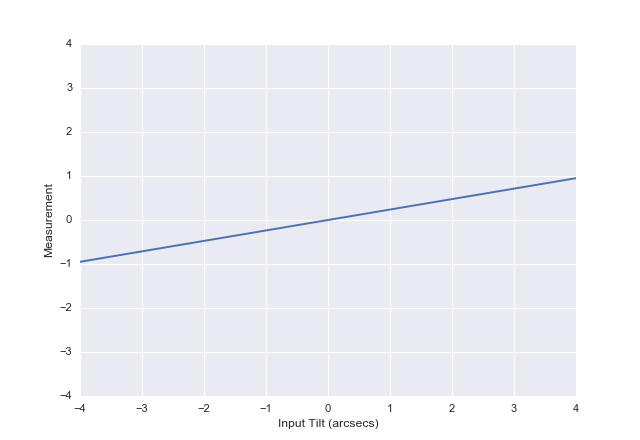

(-4, 4)

In [10]:
pyplot.figure()
pyplot.plot(tilts_asec, measuredTilts)
pyplot.xlabel('Input Tilt (arcsecs)')
pyplot.ylabel('Measurement')
pyplot.ylim(-4,4)

In [11]:
def getMeasurePixelScale(maxTilt, config, samples=50):
    
    # Measure current pixel scale
    tilts_asec = numpy.linspace(-maxTilt, maxTilt, samples)

    tilts_rad = (tilts_asec/3600.) * (numpy.pi/180)
    # Must convert arcsecs of tilt to amp in nm
    tiltAmps = 1e9 * (tilts_rad * config.tel.telDiam/2.)# in nm amp

    # Make a unit tilt to multiply
    coords = numpy.linspace(-1, 1, config.sim.pupilSize)
    coords = numpy.pad(coords, pad_width=[config.sim.simPad,]*2, mode="constant")
    tilt = numpy.meshgrid(coords, coords)[0]

    measuredTilts = numpy.zeros((tiltAmps.shape[0]))
    for i, A in enumerate(tiltAmps):
        wfs = WFS.Gradient(config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)

        aTilt = tilt*A
        slopes = wfs.frame(aTilt)
        measuredTilts[i] = -1*slopes[:wfs.activeSubaps].mean()

        # Check tilt is what I think it is
        dAmp = (aTilt.max() - aTilt.min())*1e-9
        angle = (dAmp/config.tel.telDiam) * (180./numpy.pi) * 3600

    A = numpy.vstack([tilts_asec, numpy.ones(len(tilts_asec))]).T
    grad, bias = numpy.linalg.lstsq(A, measuredTilts)[0]
    measPxlScale = 1./grad
    print("Measured Pixel Scale: {} pxls/arcsec".format(measPxlScale))

    return measPxlScale

In [12]:
pxlScales = numpy.linspace(0.05, 0.5, 10)
measPxlScales = numpy.zeros_like(pxlScales)
for ip, p in enumerate(pxlScales):
    config.wfss[0].subapFOV = config.wfss[0].pxlsPerSubap*p
    measPxlScales[ip] = getMeasurePixelScale(4*p, config, samples=20)


Measured Pixel Scale: -4.2090359866 pxls/arcsec
Measured Pixel Scale: -4.2090359866 pxls/arcsec
Measured Pixel Scale: -4.20903598864 pxls/arcsec
Measured Pixel Scale: -4.2090359866 pxls/arcsec
Measured Pixel Scale: -4.20903603697 pxls/arcsec
Measured Pixel Scale: -4.20903598864 pxls/arcsec
Measured Pixel Scale: -4.20903595692 pxls/arcsec
Measured Pixel Scale: -4.2090359866 pxls/arcsec
Measured Pixel Scale: -4.20903606305 pxls/arcsec
Measured Pixel Scale: -4.20903603697 pxls/arcsec


In [13]:
plt = bplot.figure(x_axis_label="Input Pixel Scale", y_axis_label="Measured Pixel Scale")
plt.line(pxlScales, measPxlScales)
plt.line(pxlScales, pxlScales, color="black"
    )
bplot.show(plt)

In [16]:
(wfs.wfsConfig.wavelength*1e9/(2*numpy.pi)) * (numpy.pi/180.) * (wfs.subapDiam/2.) * (1./3600)

0.00023148148148148146